In [1]:
import os
import random
import json
import numpy as np
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import argparse
from tqdm import tqdm
import time
import datetime
import torch.optim as optim

In [2]:
class CLEVR(Dataset):
    def __init__(self, root, split='train'):
        super(CLEVR, self,).__init__()
        
        assert split in ['train', 'val', 'test']
        self.split = split
        self.root_dir = root  
        self.files = os.listdir(os.path.join(self.root_dir, 'images', self.split))
        self.transform = transforms.Compose([
               transforms.ToTensor()])

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, 'images', self.split, path)).convert('RGB')
        image = image.resize((128 , 128))
        image = self.transform(image)
        sample = {'image': image}

        return sample
            
    
    def __len__(self):
        return len(self.files)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters = 3, eps = 1e-8, hidden_dim = 128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.eps = eps
        self.scale = dim ** -0.5

        self.slots_mu = nn.Parameter(torch.randn(1, 1, dim))
        self.slots_sigma = nn.Parameter(torch.rand(1, 1, dim))

        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)

        self.gru = nn.GRUCell(dim, dim)

        hidden_dim = max(dim, hidden_dim)

        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)

        self.norm_input  = nn.LayerNorm(dim)
        self.norm_slots  = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)

    def forward(self, inputs, num_slots = None):
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        
        mu = self.slots_mu.expand(b, n_s, -1)
        sigma = self.slots_sigma.expand(b, n_s, -1)
        slots = torch.normal(mu, sigma)

        inputs = self.norm_input(inputs)        
        k, v = self.to_k(inputs), self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots

            slots = self.norm_slots(slots)
            q = self.to_q(slots)

            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = dots.softmax(dim=1) + self.eps
            attn = attn / attn.sum(dim=-1, keepdim=True)

            updates = torch.einsum('bjd,bij->bid', v, attn)

            slots = self.gru(
                updates.reshape(-1, d),
                slots_prev.reshape(-1, d)
            )

            slots = slots.reshape(b, -1, d)
            slots = slots + self.fc2(F.relu(self.fc1(self.norm_pre_ff(slots))))

        return slots

def build_grid(resolution):
    ranges = [np.linspace(0., 1., num=res) for res in resolution]
    grid = np.meshgrid(*ranges, sparse=False, indexing="ij")
    grid = np.stack(grid, axis=-1)
    grid = np.reshape(grid, [resolution[0], resolution[1], -1])
    grid = np.expand_dims(grid, axis=0)
    grid = grid.astype(np.float32)
    return torch.from_numpy(np.concatenate([grid, 1.0 - grid], axis=-1)).to(device)

"""Adds soft positional embedding with learnable projection."""
class SoftPositionEmbed(nn.Module):
    def __init__(self, hidden_size, resolution):
        """Builds the soft position embedding layer.
        Args:
        hidden_size: Size of input feature dimension.
        resolution: Tuple of integers specifying width and height of grid.
        """
        super().__init__()
        self.embedding = nn.Linear(4, hidden_size, bias=True)
        self.grid = nn.Parameter(build_grid(resolution), requires_grad=False)

    def forward(self, inputs):
        grid = self.embedding(self.grid)
        return inputs + grid

class Encoder(nn.Module):
    def __init__(self, resolution, hid_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, hid_dim, 5, padding = 2)
        self.conv2 = nn.Conv2d(hid_dim, hid_dim, 5, padding = 2)
        self.conv3 = nn.Conv2d(hid_dim, hid_dim, 5, padding = 2)
        self.conv4 = nn.Conv2d(hid_dim, hid_dim, 5, padding = 2)
        self.encoder_pos = SoftPositionEmbed(hid_dim, resolution)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = x.permute(0,2,3,1)
        x = self.encoder_pos(x)
        x = torch.flatten(x, 1, 2)
        return x

class Decoder(nn.Module):
    def __init__(self, hid_dim, resolution):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        self.conv2 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        self.conv3 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        self.conv4 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(2, 2), padding=2, output_padding=1).to(device)
        self.conv5 = nn.ConvTranspose2d(hid_dim, hid_dim, 5, stride=(1, 1), padding=2).to(device)
        self.conv6 = nn.ConvTranspose2d(hid_dim, 4, 3, stride=(1, 1), padding=1)
        self.decoder_initial_size = (8, 8)
        self.decoder_pos = SoftPositionEmbed(hid_dim, self.decoder_initial_size)
        self.resolution = resolution

    def forward(self, x):
        x = self.decoder_pos(x)
        x = x.permute(0,3,1,2)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
#         x = F.pad(x, (4,4,4,4)) # no longer needed
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = x[:,:,:self.resolution[0], :self.resolution[1]]
        x = x.permute(0,2,3,1)
        return x

"""Slot Attention-based auto-encoder for object discovery."""
class SlotAttentionAutoEncoder(nn.Module):
    def __init__(self, resolution, num_slots, num_iterations, hid_dim):
        """Builds the Slot Attention-based auto-encoder.
        Args:
        resolution: Tuple of integers specifying width and height of input image.
        num_slots: Number of slots in Slot Attention.
        num_iterations: Number of iterations in Slot Attention.
        """
        super().__init__()
        self.hid_dim = hid_dim
        self.resolution = resolution
        self.num_slots = num_slots
        self.num_iterations = num_iterations

        self.encoder_cnn = Encoder(self.resolution, self.hid_dim)
        self.decoder_cnn = Decoder(self.hid_dim, self.resolution)

        self.fc1 = nn.Linear(hid_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)

        self.slot_attention = SlotAttention(
            num_slots=self.num_slots,
            dim=hid_dim,
            iters = self.num_iterations,
            eps = 1e-8, 
            hidden_dim = 128)

    def forward(self, image):
        # `image` has shape: [batch_size, num_channels, width, height].

        # Convolutional encoder with position embedding.
        x = self.encoder_cnn(image)  # CNN Backbone.
        x = nn.LayerNorm(x.shape[1:]).to(device)(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)  # Feedforward network on set.
        # `x` has shape: [batch_size, width*height, input_size].

        # Slot Attention module.
        slots = self.slot_attention(x)
        # `slots` has shape: [batch_size, num_slots, slot_size].

        # """Broadcast slot features to a 2D grid and collapse slot dimension.""".
        x = slots.reshape((-1, slots.shape[-1])).unsqueeze(1).unsqueeze(2)
        x = x.repeat((1, 8, 8, 1))
        
        # `slots` has shape: [batch_size*num_slots, width_init, height_init, slot_size].
        x = self.decoder_cnn(x)
        # `x` has shape: [batch_size*num_slots, width, height, num_channels+1].

        # Undo combination of slot and batch dimension; split alpha masks.
        recons, masks = x.reshape(image.shape[0], -1, x.shape[1], x.shape[2], x.shape[3]).split([3,1], dim=-1)
        # `recons` has shape: [batch_size, num_slots, width, height, num_channels].
        # `masks` has shape: [batch_size, num_slots, width, height, 1].

        # Normalize alpha masks over slots.
        masks = nn.Softmax(dim=1)(masks)
        recon_combined = torch.sum(recons * masks, dim=1)  # Recombine image.
        recon_combined = recon_combined.permute(0,3,1,2)
        # `recon_combined` has shape: [batch_size, width, height, num_channels].

        return recon_combined, recons, masks, slots

In [4]:
parser = argparse.ArgumentParser()

parser.add_argument
parser.add_argument('--model_dir', default='/kaggle/working/model1.ckpt', type=str, help='where to save models' )
parser.add_argument('--seed', default=0, type=int, help='random seed')
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--num_slots', default=8, type=int, help='Number of slots in Slot Attention.')
parser.add_argument('--num_iterations', default=3, type=int, help='Number of attention iterations.')
parser.add_argument('--hid_dim', default=64, type=int, help='hidden dimension size')
parser.add_argument('--learning_rate', default=0.0004, type=float)
parser.add_argument('--warmup_steps', default=10000, type=int, help='Number of warmup steps for the learning rate.')
parser.add_argument('--decay_rate', default=0.5, type=float, help='Rate for the learning rate decay.')
parser.add_argument('--decay_steps', default=100000, type=int, help='Number of steps for the learning rate decay.')
parser.add_argument('--num_workers', default=8, type=int, help='number of workers for loading data')
parser.add_argument('--num_epochs', default=1, type=int, help='number of workers for loading data')

opt, unknown = parser.parse_known_args()
resolution = (128, 128)

train_set = CLEVR('/kaggle/input/clevr-dataset/CLEVR_v1.0', 'train')
model = SlotAttentionAutoEncoder(resolution, opt.num_slots, opt.num_iterations, opt.hid_dim)
# model.load_state_dict(torch.load('./tmp/model6.ckpt')['model_state_dict'])

model = nn.DataParallel(model)
model.to(device)

criterion = nn.MSELoss()

params = [{'params': model.parameters()}]

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=opt.batch_size,
                        shuffle=True, num_workers=opt.num_workers, pin_memory=True)

optimizer = optim.Adam(params, lr=opt.learning_rate)

def train_model():
    start = time.time()
    i = 0
    for epoch in range(opt.num_epochs):
        model.train()

        total_loss = 0

        for sample in tqdm(train_dataloader):
            i += 1

            if i < opt.warmup_steps:
                learning_rate = opt.learning_rate * (i / opt.warmup_steps)
            else:
                learning_rate = opt.learning_rate

            learning_rate = learning_rate * (opt.decay_rate ** (
                i / opt.decay_steps))

            optimizer.param_groups[0]['lr'] = learning_rate

            image = sample['image'].to(device)
            recon_combined, recons, masks, slots = model(image)
            loss = criterion(recon_combined, image)
            total_loss += loss.item()

            del recons, masks, slots

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss /= len(train_dataloader)

        print ("Epoch: {}, Loss: {}, Time: {}".format(epoch, total_loss,
            datetime.timedelta(seconds=time.time() - start)))

        if not epoch % 10:
            torch.save({
                'model_state_dict': model.state_dict(),
                }, opt.model_dir)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
from pathlib import Path
import cv2
from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained model and processor
encoder_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
encoder_model.to(device)

class COMPHY(Dataset):    
    def __init__(self, root):
        super(COMPHY, self,).__init__()
        self.root_dir = root
        self.files = list(Path(root).rglob("*.mp4"))
        self.process = process_video

    def __getitem__(self, index):
        path = self.files[index]
        frame_array = self.process(path)
        items = str(path).split('/')
        name = items[6].split('.')[0]
        return np.array(frame_array), name
    
    def __len__(self):
        return len(self.files)
    
# Convert video in path to array of frames at rate of 1 FPS
def process_video(path):
    KPS = 1 # Target Keyframes Per Second
    frame_array = []
    vidObj = cv2.VideoCapture(str(path))
    success = 1
    count = 0
    fps = round(vidObj.get(cv2.CAP_PROP_FPS))
    hop = round(fps / KPS)
    transform = transforms.Compose([transforms.ToTensor()])
    while(success):
        success,img = vidObj.read()
        if img is not None and count % hop == 0:
            resized = cv2.resize(img, (128, 128))
            im = Image.fromarray(np.uint8(resized)).convert('RGB')
            im = transform(im)
            frame_array.append(im)
        count += 1
    return frame_array

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

2024-04-20 10:55:59.784752: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 10:55:59.784906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 10:55:59.917032: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [6]:
dataset = COMPHY('/kaggle/input/comphy/target')

import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance
# Hyperparameters.
seed = 0
batch_size = 1
num_slots = 8
num_iterations = 3
resolution = (128, 128)

resolution = (128, 128)
model = SlotAttentionAutoEncoder(resolution, num_slots, num_iterations, 64)
model.load_state_dict(torch.load('/kaggle/input/modelcheckpnt/model.ckpt')['model_state_dict'], strict=False)
model.to(device)

slot_array = {}
for video, name in tqdm(dataset):
    video_slot = []
    for frame in video:
        image = torch.from_numpy(frame)
        image = image.unsqueeze(0).to(device)
        _,_,_,slots = model(image)
        video_slot.append(slots.squeeze().detach().cpu().numpy())
    slot_array[name] = np.array(video_slot)


  0%|          | 0/10000 [00:01<?, ?it/s]


In [7]:
TMP_DIR = Path('../temp')
TMP_DIR.mkdir(exist_ok=True)

In [8]:
import pickle
with open('slow_out.pkl','wb') as f:
    pickle.dump(slot_array, f)

In [9]:
import zipfile
import tempfile
for video in slot_array:
#     with open(str(TMP_DIR) + '/' + video+'_slow.pkl','wb') as f:
#         pickle.dump(slot_array[video], f)
    with tempfile.NamedTemporaryFile(dir=TMP_DIR) as f:
        pickle.dump(slot_array[video], f)
        with zipfile.ZipFile('/kaggle/working/slow.zip', "a", compression=zipfile.ZIP_DEFLATED) as zipf:
            zipf.write(f.name, video+'_slow.pkl')

(6, 8, 64)


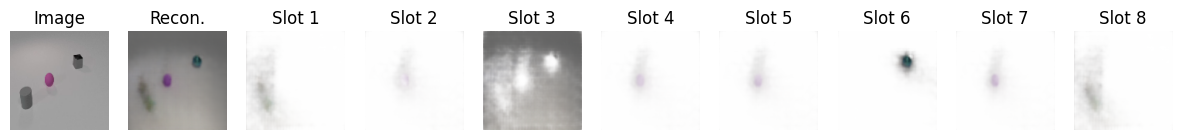

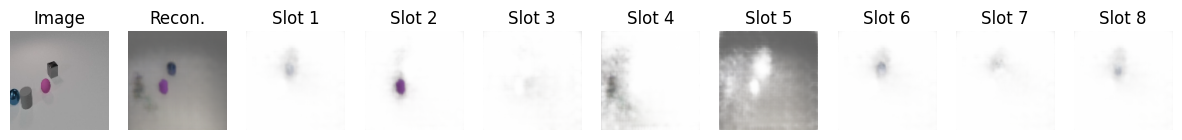

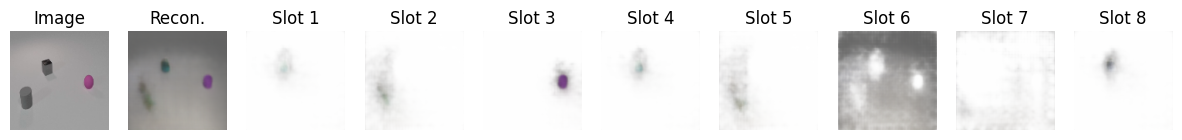

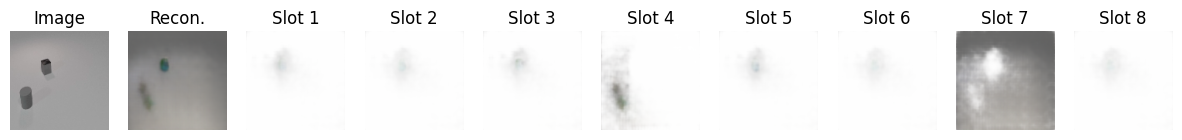

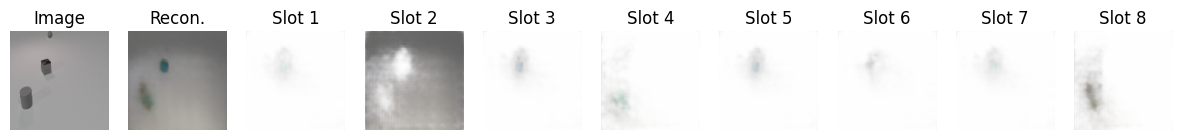

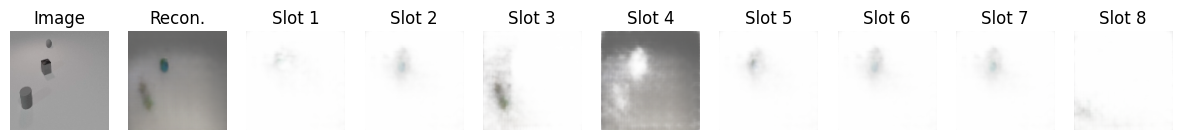

In [10]:
test_set = CLEVR('/kaggle/input/clevr-dataset/CLEVR_v1.0', 'test')

# image = test_set[2]['image']
frames, name = dataset[0]
for frame in frames:
    image = torch.from_numpy(frame)
    image = image.unsqueeze(0).to(device)
    recon_combined, recons, masks, slots = model(image)
    fig, ax = plt.subplots(1, num_slots + 2, figsize=(15, 2))
    image = image.squeeze(0)
    recon_combined = recon_combined.squeeze(0)
    recons = recons.squeeze(0)
    masks = masks.squeeze(0)
    image = image.permute(1,2,0).cpu().numpy()
    recon_combined = recon_combined.permute(1,2,0)
    recon_combined = recon_combined.cpu().detach().numpy()
    recons = recons.cpu().detach().numpy()
    masks = masks.cpu().detach().numpy()
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(recon_combined)
    ax[1].set_title('Recon.')
    for i in range(num_slots):
        picture = recons[i] * masks[i] + (1 - masks[i])
        ax[i + 2].imshow(picture)
        ax[i + 2].set_title('Slot %s' % str(i + 1))
    for i in range(len(ax)):
        ax[i].grid(False)
        ax[i].axis('off')